In [3]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import time
import scipy.optimize

In [4]:
n = 1000

n1 = 300
n2 = 300
n3 = 400
G1 = nx.gnp_random_graph(n1, 0.2)
G2 = nx.gnp_random_graph(n2, 0.2)
G3 = nx.gnp_random_graph(n3, 0.2)
G = nx.disjoint_union(G1, G2)
G = nx.disjoint_union(G, G3)

In [5]:
t0 = time.perf_counter()
pos = nx.spring_layout(G)
print(time.perf_counter() - t0)

5.98692470008973


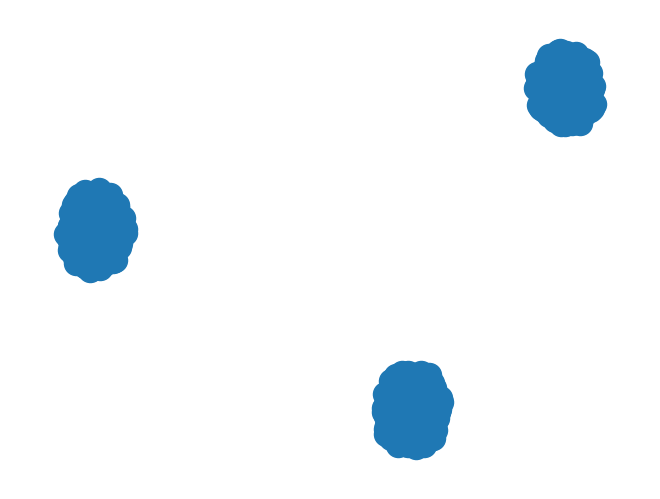

In [6]:
nx.draw(G, pos)
plt.show()

In [35]:
from networkx.utils import np_random_state
from networkx.drawing.layout import _process_params, rescale_layout


def cost_function(A, k, pos):
    ret = 0.0
    for i in range(pos.shape[0]):
        for j in range(i + 1, pos.shape[0]):
            delta = pos[i] - pos[j]
            dist = np.linalg.norm(delta)
            ret += k**2 / dist + A[i, j] * (dist**2) / (2 * k)
    return ret


@np_random_state(10)
def spring_layout(
    G,
    k=None,
    pos=None,
    fixed=None,
    iterations=50,
    threshold=1e-4,
    weight="weight",
    scale=1,
    center=None,
    dim=2,
    seed=None,
):
    import numpy as np

    G, center = _process_params(G, center, dim)

    if fixed is not None:
        if pos is None:
            raise ValueError("nodes are fixed without positions given")
        for node in fixed:
            if node not in pos:
                raise ValueError("nodes are fixed without positions given")
        nfixed = {node: i for i, node in enumerate(G)}
        fixed = np.asarray([nfixed[node] for node in fixed if node in nfixed])

    if pos is not None:
        # Determine size of existing domain to adjust initial positions
        dom_size = max(coord for pos_tup in pos.values() for coord in pos_tup)
        if dom_size == 0:
            dom_size = 1
        pos_arr = seed.rand(len(G), dim) * dom_size + center

        for i, n in enumerate(G):
            if n in pos:
                pos_arr[i] = np.asarray(pos[n])
    else:
        pos_arr = None
        dom_size = 1

    if len(G) == 0:
        return {}
    if len(G) == 1:
        return {nx.utils.arbitrary_element(G.nodes()): center}

    try:
        raise ValueError
    except ValueError:
        A = nx.to_numpy_array(G, weight=weight)
        if k is None and fixed is not None:
            # We must adjust k by domain size for layouts not near 1x1
            nnodes, _ = A.shape
            k = dom_size / np.sqrt(nnodes)
        pos = _fruchterman_reingold(
            A, k, pos_arr, fixed, iterations, threshold, dim, seed
        )
    if fixed is None and scale is not None:
        pos = rescale_layout(pos, scale=scale) + center
    pos = dict(zip(G, pos))
    return pos


fruchterman_reingold_layout = spring_layout


@np_random_state(7)
def _fruchterman_reingold(
    A, k=None, pos=None, fixed=None, iterations=50, threshold=1e-4, dim=2, seed=None
):
    # Position nodes in adjacency matrix A using Fruchterman-Reingold
    # Entry point for NetworkX graph is fruchterman_reingold_layout()
    import numpy as np

    try:
        nnodes, _ = A.shape
    except AttributeError as err:
        msg = "fruchterman_reingold() takes an adjacency matrix as input"
        raise nx.NetworkXError(msg) from err

    if pos is None:
        # random initial positions
        pos = np.asarray(seed.rand(nnodes, dim), dtype=A.dtype)
    else:
        # make sure positions are of same type as matrix
        pos = pos.astype(A.dtype)

    # optimal distance between nodes
    if k is None:
        k = np.sqrt(1.0 / nnodes)
    # the initial "temperature"  is about .1 of domain area (=1x1)
    # this is the largest step allowed in the dynamics.
    # We need to calculate this in case our fixed positions force our domain
    # to be much bigger than 1x1
    t = max(max(pos.T[0]) - min(pos.T[0]), max(pos.T[1]) - min(pos.T[1])) * 0.1
    # simple cooling scheme.
    # linearly step down by dt on each iteration so last iteration is size dt.
    dt = t / (iterations + 1)
    delta = np.zeros((pos.shape[0], pos.shape[0], pos.shape[1]), dtype=A.dtype)
    # the inscrutable (but fast) version
    # this is still O(V^2)
    # could use multilevel methods to speed this up significantly
    costs = []
    for iteration in range(iterations):
        # matrix of difference between points
        delta = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
        # distance between points
        distance = np.linalg.norm(delta, axis=-1)
        # enforce minimum distance of 0.01
        np.clip(distance, 0.01, None, out=distance)
        # displacement "force"
        displacement = np.einsum(
            "ijk,ij->ik", delta, (k * k / distance**2 - A * distance / k)
        )
        # update positions
        length = np.linalg.norm(displacement, axis=-1)
        length = np.where(length < 0.01, 0.1, length)
        delta_pos = np.einsum("ij,i->ij", displacement, t / length)
        if fixed is not None:
            # don't change positions of fixed nodes
            delta_pos[fixed] = 0.0
        pos += delta_pos
        # cool temperature
        t -= dt
        print(f"iteration {iteration} cost {cost_function(A, k, pos)}")
        costs.append(cost_function(A, k, pos))
        if (np.linalg.norm(delta_pos) / nnodes) < threshold:
            break
    plt.plot(costs)
    plt.show()
    return pos

iteration 0 cost 17.208882214311963
iteration 1 cost 16.03179509745051
iteration 2 cost 17.072946246067715
iteration 3 cost 15.682697648446963
iteration 4 cost 15.200402101268988
iteration 5 cost 14.132407010260241
iteration 6 cost 13.70508556377772
iteration 7 cost 12.935350360270059
iteration 8 cost 12.845679255923036
iteration 9 cost 12.39854619374217
iteration 10 cost 12.389163982456846
iteration 11 cost 12.268941803046818
iteration 12 cost 12.300800804816536
iteration 13 cost 12.189867518629871
iteration 14 cost 12.31672990200706
iteration 15 cost 12.157313437013931
iteration 16 cost 12.303915950896734
iteration 17 cost 12.140518748421323
iteration 18 cost 12.294666947466263
iteration 19 cost 12.139539289184526
iteration 20 cost 12.282077783026741
iteration 21 cost 12.133350762313855
iteration 22 cost 12.261099049603514
iteration 23 cost 12.126503576664
iteration 24 cost 12.241933464537784
iteration 25 cost 12.118843578969917
iteration 26 cost 12.225330761983475
iteration 27 cost 

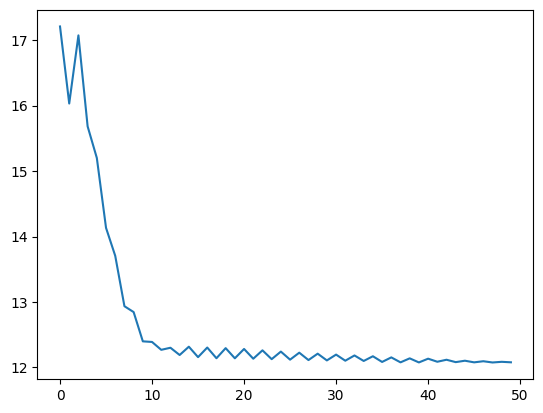

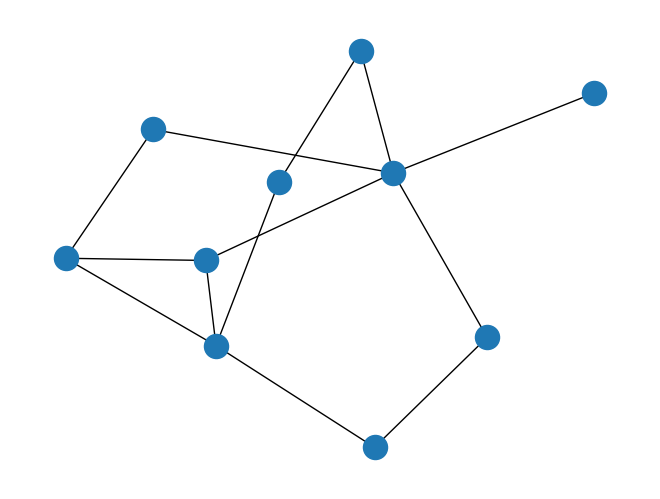

In [36]:
n = 10
G = nx.gnp_random_graph(n, 0.2)
pos = spring_layout(G)
nx.draw(G, pos)

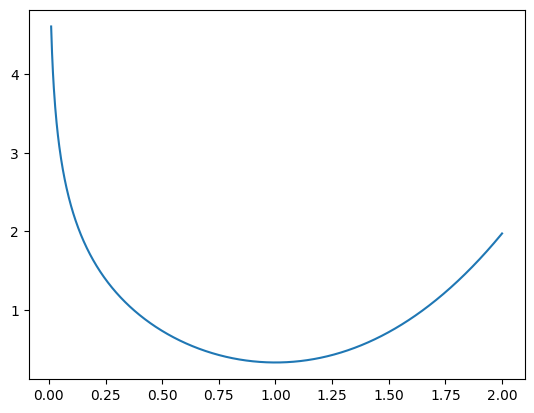

In [31]:
d = np.linspace(0.01, 2, 1000)
k = 1
e = (1 / 3) * (d**3) / k - (k**2) * np.log(d)
plt.plot(d, e)
plt.show()